In [1]:
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.messages.tool import tool_call, ToolMessage
from langgraph.graph import StateGraph, START, END
import json
from owlready2 import get_ontology, Ontology, ThingClass
from ontology_parser import *
from typing import Annotated, List, Dict, Any
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI
from langchain_core.tools import Tool, tool
from langgraph.prebuilt import ToolNode, tools_condition
from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv(),override=True)

True

In [2]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.3)

In [17]:
@tool
def find_relevant_classes(query : str) -> List[Dict[str, Any]]:
    """
    Finds classes relevant to the user query.
    :param query_dict: User query string.
    :return: List of relevant classes.
    """
    print("T"*10)
    ontology = load_ontology("OWLs/SOMA.owl")
    class_details = extract_all_class_details(ontology)

    relevant_classes = ["srikanth"]
    query_lower = query.lower()
    for class_detail in class_details:
        if query_lower in class_detail["name"].lower():
            relevant_classes.append(class_detail)
        else:
            for comment_value in class_detail["comment"]:
                if query_lower in str(comment_value).lower():
                    relevant_classes.append(class_detail)
    return relevant_classes

@tool
def multiply(a: int, b: int) -> int:
    """Multiply a and b."""
    return a * b

In [4]:
tools = [find_relevant_classes, multiply]

In [5]:
llm_with_tools = llm.bind_tools(tools)

In [6]:
def onto_agent(state: State):
    print("A"*10)
    print(state["messages"])
    return {"messages" : [llm_with_tools.invoke(state["messages"])]}

In [7]:
class BasicToolNode:
    def __init__(self, tools : list):
        self.tools_by_name = {tool.name:tool for tool in tools}

    def __call__(self, inputs: dict):

        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No Message found in input")

        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content = json.dumps(tool_result),
                    name = tool_call["name"],
                    tool_call_id = tool_call["id"]
                )
            )
        return {"messages" : outputs }

In [8]:
tool_node = BasicToolNode(tools=tools)

In [9]:
graph_builder.add_node("agent", onto_agent)
graph_builder.add_node("tools", tool_node)

In [10]:
def route_tools(state: State):
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END

In [11]:
graph_builder.add_conditional_edges("agent", route_tools, {"tools": "tools", END: END})

In [12]:
graph_builder.add_edge("tools", "agent")
graph_builder.add_edge(START, "agent")

In [13]:
graph = graph_builder.compile()

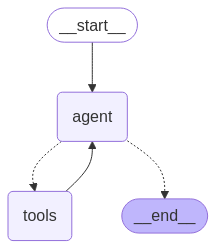

In [14]:
from IPython.display import display, Image
display(Image(graph.get_graph().draw_mermaid_png()))

In [18]:
ans = graph.invoke({"messages" : [HumanMessage(content="navigating")]})

AAAAAAAAAA
[HumanMessage(content='navigating', additional_kwargs={}, response_metadata={}, id='57138174-b11f-4841-a5d0-78ac05aea9f0')]
AAAAAAAAAA
[HumanMessage(content='navigating', additional_kwargs={}, response_metadata={}, id='57138174-b11f-4841-a5d0-78ac05aea9f0'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_WUD6tb5rNB0PNXp3PbiYmPjx', 'function': {'arguments': '{"query":"navigating"}', 'name': 'find_relevant_classes'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 89, 'total_tokens': 108, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_06737a9306', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-5a616f38-7137-4430-b7ec-4a8776b8b497-0', tool_calls=[{'name': '

In [22]:
ans

{'messages': [HumanMessage(content='navigating', additional_kwargs={}, response_metadata={}, id='57138174-b11f-4841-a5d0-78ac05aea9f0'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_WUD6tb5rNB0PNXp3PbiYmPjx', 'function': {'arguments': '{"query":"navigating"}', 'name': 'find_relevant_classes'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 89, 'total_tokens': 108, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_06737a9306', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-5a616f38-7137-4430-b7ec-4a8776b8b497-0', tool_calls=[{'name': 'find_relevant_classes', 'args': {'query': 'navigating'}, 'id': 'call_WUD6tb5rNB0PNXp3PbiYmPjx', 'type': 'tool_call'}], usage_metada

In [27]:
def stream_graph_updates(user_input: str):
    state = {"messages": [HumanMessage(content=user_input)]}
    for event in graph.stream(state):
        for node_output in event.values():
            if "messages" in node_output:
                messages = node_output["messages"]
                if messages:
                    last_message = messages[-1]

                    if isinstance(last_message, HumanMessage):
                        print(f"Human: {last_message.content}")
                    elif isinstance(last_message, AIMessage):
                        print(f"AI: {last_message.content}")
                        if hasattr(last_message, "tool_calls") and last_message.tool_calls:
                            for tool_call in last_message.tool_calls:
                                print(f"  Tool: {tool_call['name']}")
                                print(f"  Tool Args: {tool_call['args']}")
                                tool_results = tool_node({"messages": [last_message]})
                                tool_result_message = tool_results["messages"][-1]
                                if isinstance(tool_result_message, ToolMessage):
                                    print(f"  Tool Result: {tool_result_message.content}")
                    elif isinstance(last_message, ToolMessage):
                        print(f"Tool Result: {last_message.content}")

In [29]:
stream_graph_updates("navigating")

AAAAAAAAAA
[HumanMessage(content='navigating', additional_kwargs={}, response_metadata={}, id='f796ce54-a425-4591-897b-f7615b68cdfe')]
AI: 
  Tool: find_relevant_classes
  Tool Args: {'query': 'navigating'}
AAAAAAAAAA
[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_SLLYnVDYTfMwkP5GcGqouHx1', 'function': {'arguments': '{"query":"navigating"}', 'name': 'find_relevant_classes'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 89, 'total_tokens': 108, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_06737a9306', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-aa4302f1-046c-46fc-8b7f-19fad7bf1de5-0', tool_calls=[{'name': 'find_relevant_classes', 'args': {'query': 'navigati

BadRequestError: Error code: 400 - {'error': {'message': "An assistant message with 'tool_calls' must be followed by tool messages responding to each 'tool_call_id'. The following tool_call_ids did not have response messages: call_SLLYnVDYTfMwkP5GcGqouHx1", 'type': 'invalid_request_error', 'param': 'messages', 'code': None}}

### Direct Tool Invocation

In [20]:
result = llm_with_tools.invoke("what is 6 times 12")

In [21]:
print(result.tool_calls)
args = result.tool_calls[0]['args']
print(args)

[{'name': 'multiply', 'args': {'a': 6, 'b': 12}, 'id': 'call_E1OpCBuGusrPNfDmiKYhfekZ', 'type': 'tool_call'}]
{'a': 6, 'b': 12}


In [22]:
multiply.invoke(args)

72

In [23]:
result = llm_with_tools.invoke("relevant classes to grasping")
result.tool_calls

[{'name': 'find_relevant_classes',
  'args': {'query': 'grasping'},
  'id': 'call_OPUNUGQoQ4drXiSsFzkgxvpw',
  'type': 'tool_call'}]

In [24]:
args = result.tool_calls[0]['args']
args

{'query': 'grasping'}

In [26]:
find_relevant_classes.invoke(args)

['srikanth',
 {'name': 'FactualBinding',
  'iri': 'http://www.ease-crc.org/ont/SOMA.owl#FactualBinding',
  'subclasses': [],
  'comment': ['FactualBindings are used in a workflow to assert that:\n\n-- task- or workflow-defined roles share fillers (RoleRoleBindings). Example, the instrument of a cutting task may be the actee of a grasping task;\n-- task- or workflow-defined roles are filled by a particular entity (RoleFillerBindings). This is typically the case when roles, and especially parameters, can be assigned to constants. Example, the waiting time to cook soft eggs is 3 minutes.']},
 {'name': 'Catching',
  'iri': 'http://www.ease-crc.org/ont/SOMA.owl#Catching',
  'subclasses': [],
  'comment': ['A task by which an Agent stops a moving object and gains kinematic control over it, usually by grasping.']},
 {'name': 'Finger',
  'iri': 'http://www.ease-crc.org/ont/SOMA.owl#Finger',
  'subclasses': [],
  'comment': ['A limb used for grasping objects.']},
 {'name': 'Grasping',
  'iri': 